In [9]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#!/usr/bin/env python
from __future__ import print_function

import argparse
import random
import numpy as np
from collections import deque

import json
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Data Dictionary : Yellow Taxi Cab
- VendorID A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
- tpep_pickup_datetime The date and time when the meter was engaged.
- tpep_dropoff_datetime The date and time when the meter was disengaged.
- Passenger_count The number of passengers in the vehicle.
 This is a driver-entered value.
- Trip_distance The elapsed trip distance in miles reported by the taximeter.
- Pickup_longitude Longitude where the meter was engaged.
- Pickup_latitude Latitude where the meter was engaged.
- RateCodeID The final rate code in effect at the end of the trip.
 1= Standard rate 
 2=JFK
 3=Newark
 4=Nassau or Westchester
 5=Negotiated fare
 6=Group ride
- Store_and_fwd_flag This flag indicates whether the trip record was held in vehicle
 memory before sending to the vendor, aka “store and forward,”
 because the vehicle did not have a connection to the server.
- Y= store and forward trip
- N= not a store and forward trip
- Dropoff_longitude Longitude where the meter was disengaged.
- Dropoff_ latitude Latitude where the meter was disengaged.
- Payment_type A numeric code signifying how the passenger paid for the trip.
 1= Credit card
 2= Cash
 3= No charge
 4= Dispute
 5= Unknown
 6= Voided trip
- Fare_amount The time-and-distance fare calculated by the meter.
- Extra Miscellaneous extras and surcharges. Currently, this only includes
 t he 0.50 and 1 rush hour and overnight charges.
 M TA_tax 0.50 MTA tax that is automatically triggered based on the metered
 rate in use.
- Improvement_surcharge 0.30 improvement surcharge assessed trips at the flag drop. The
- improvement surcharge began being levied in 2015.
- Tip_amount Tip amount – This field is automatically populated for credit card
 tips. Cash tips are not included.
- Tolls_amount Total amount of all tolls paid in trip.
- Total_amount The total amount charged to passengers. Does not include cash tips.

### Geohash dictionary the distance between geohashes based on matching characters, in meters.
_PRECISION = {
    0: 20000000,
    1: 5003530,
    2: 625441,
    3: 123264,
    4: 19545,
    5: 3803,
    6: 610,
    7: 118,
    8: 19,
    9: 3.71,
    10: 0.6,
}

### Average speed of taxis in Manhattan
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [10]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df = pd.read_csv("data/yellow_taxi_geohash_min_day.csv")

In [11]:
# Encoding error
taxi_yellowcab_df['geohash_dropoff']=taxi_yellowcab_df['geohas_dropoff']
#drop unnecessary columns
taxi_yellowcab_df.drop(['Unnamed: 0','Unnamed: 0.1'],inplace=True,axis=1)

In [12]:
taxi_yellowcab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906858 entries, 0 to 10906857
Data columns (total 24 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
geohash_pickup           object
geohas_dropoff           object
jan_day                  int64
jan_minute               int64
geohash_dropoff          object
dtypes: float64(12), int64(6), object(6)
memory usage: 2.0+ GB


In [13]:
taxi_yellowcab_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx,1,0,dr5rsx
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk,1,0,dr5rtk
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1,1,0,dr72j1
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc,1,0,dr5rkc
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue,1,0,dr5rue
5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,0.5,0.0,0.0,0.3,20.3,dr5ru9,dr5ryh,1,18,dr5ryh
6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,...,0.5,0.0,0.0,0.3,27.3,dr5rsh,dr72hc,1,26,dr72hc
7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,...,0.5,0.0,0.0,0.3,10.3,dr5ru9,dr5ru7,1,11,dr5ru7
8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,...,0.5,0.0,0.0,0.3,19.3,dr72j3,dr72mz,1,11,dr72mz
9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,...,0.5,0.0,0.0,0.3,12.8,dr5rsj,dr5rkp,1,11,dr5rkp


In [14]:
from datetime import datetime, timedelta, date
import dateutil
st_date = '2016-11-01'
dt = dateutil.parser.parse(st_date).date()
dt

datetime.date(2016, 11, 1)

## Create new columns for the day, minute, and month of january
- Don't run again, save this as csv

In [15]:
#taxi_yellowcab_df['jan_day']=[dateutil.parser.parse(i).day for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [16]:
#taxi_yellowcab_df['jan_minute']=[dateutil.parser.parse(i).minute for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [17]:
#taxi_yellowcab_df.to_csv("data/yellow_taxi_geohash_min_day.csv")

In [327]:
#taxi_yellowcab_df['month'] =[i.month for i in taxi_yellowcab_df.tpep_pickup_datetime]

In [329]:
#taxi_yellowcab_df['month'].unique()

array([1])

In [328]:
## filter to only have dates from January
#taxi_yellowcab_df[taxi_yellowcab_df['month']==2]

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,month


- Transform lat and long to zip code

>zip_code_data from: https://github.com/EverythingMe/geodis


### Create a geohash of the latitude and longtitude of the pickup and dropoff

In [67]:
def geohash_encoding(taxi_df,precision_=5):
    """Encode the latitude and longtitude of the pickup and dropoff into a geohash. For reference, the precision
    of a geohash depends on the number of characters present.
    _PRECISION = { 0: 20000000, 1: 5003530, 2: 625441, 3: 123264, 4: 19545,
    5: 3803, 6: 610, 7: 118, 8: 19, 9: 3.71, 10: 0.6, } - all distances in meters.
    
    Average taxi speed in 2014 was 5.51 miles per hour, or 3.8 meters per second.
    Precision of 5, means that a taxi should traverse this square in ~16 minutes avg. speed 8.6 MPH.
    Precision of 6, means a taxi should traverse square in ~3 minutes using average speed of 8.6mph.
    Precision of 7, means a taxi should traverse the square in ~1 minute.
    
    Input: Pandas DF
    Output: Pandas DF with geohas column appended"""
    new_taxidf = taxi_df.copy()
    geo_hash_pickup = []
    geo_hash_dropoff = []
    for idx,row in enumerate(new_taxidf.iterrows()):
        if idx%100000==0:
            print("Finished row number {}".format(idx))
        # longittude followed by latitude

            pickup_vector = np.array( [row[1]['pickup_latitude'],row[1]['pickup_longitude']])
            dropoff_vector = np.array( [row[1]['dropoff_latitude'],row[1]['dropoff_longitude']])
            #geohash encoding
            has = gh.encode(pickup_vector[1],pickup_vector[0],precision_)
            geo_hash_pickup.append(gh.encode(pickup_vector[0],pickup_vector[1],precision_))
            geo_hash_dropoff.append(gh.encode(dropoff_vector[0],dropoff_vector[1],precision_))
        else:
            pickup_vector = np.array( [row[1]['pickup_latitude'],row[1]['pickup_longitude']])
            dropoff_vector = np.array( [row[1]['dropoff_latitude'],row[1]['dropoff_longitude']])
            #geohash encoding
            has = gh.encode(pickup_vector[1],pickup_vector[0],precision_)
            geo_hash_pickup.append(gh.encode(pickup_vector[0],pickup_vector[1],precision_))
            geo_hash_dropoff.append(gh.encode(dropoff_vector[0],dropoff_vector[1],precision_))

    ## add in the new geohash columns
    new_taxidf['geohash_pickup'] = geo_hash_pickup
    new_taxidf['geohash_dropoff'] = geo_hash_dropoff 
    return new_taxidf
        
    
    

> Time how long this will take to run for 10 million rows
- 1k samples takes .297 seconds
- 10k samples takes 2.34 seconds
- 10 million rows is 1,000x 10k so 2340 seconds or 39 minutes

In [32]:
taxi_yellowcab_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx,1,0,dr5rsx
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk,1,0,dr5rtk
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1,1,0,dr72j1
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc,1,0,dr5rkc
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue,1,0,dr5rue


In [55]:
gh.encode(40.768951416,-73.9919967651,5)

'Zct9T'

In [122]:
# Already ran this
#taxi_yellowcab_jan_geohash_df = geohash_encoding(taxi_yellowcab_df)

In [69]:
taxi_yellowcab_jan_geohash_df .head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,0.5,0.0,0.0,0.3,8.8,Zct8X,dr5rsx,1,0,Zct8d
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,0.5,0.0,0.0,0.3,19.3,Zct8c,dr5rtk,1,0,Zct8y
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,0.5,0.0,0.0,0.3,34.3,Zct5T,dr72j1,1,0,Zc4oh
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,0.5,0.0,0.0,0.3,17.3,Zct8Q,dr5rkc,1,0,Zct5L
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,0.5,0.0,0.0,0.3,8.8,Zc4oK,dr5rue,1,0,Zct9N


In [70]:
#taxi_yellowcab_jan_geohash_df.to_csv("data/yellow_taxi_geohash_min_day.csv")

In [18]:
taxi_yellowcab_df .head()

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,...,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx,1,0,dr5rsx
1,1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,...,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk,1,0,dr5rtk
2,2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,...,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1,1,0,dr72j1
3,3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,...,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc,1,0,dr5rkc
4,4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,...,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue,1,0,dr5rue


# Finding neighbors from a dropoff geohash
- use gh.neighbors
- Convert these neighbors to an output index from the neural network

In [123]:
gh.neighbors(taxi_yellowcab_df.geohash_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

In [152]:
# Dictionary to convert these distances into the output from the Neural Network
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
list_of_output_predictions_to_direction={0:'nw',1:'n',2:'ne',3:'w',4:'stay',5:'e',6:'sw',7:'s',8:'se'}

# How many different paths are there for a cab driver to take
- 1) Assuming you can go to every geohash (not possible)
- 2) In a day

In [125]:
# How many total paths are there? Each hash has eight neighbors 9**(3086+1)-1 (nine because can go back to same node)?
len(str(9**(3086+1)-1))

2946

In [126]:
9**(3086+1)-1

5579902870072604520781768502574482838546250466479394679120423233865123088592389991017461272488545405947765927162973387932045022005649438467688986550554080894185396774521488734899097433560201783213247514879997422269344026429651880573126493783573017994538196988029386545666816019319724615929720075669428086745884640756582690931484927980211133964573153734354721166826860261443322744314068689260103258399221523423491086073730155749220812428859992609815473080036165549503067436533672536096771042279671074422297963752772874873262444107295806867918725513984107605763341504022359073978439306375832553510771427946743018584229245035857393349814173061883996462261039520359742300610335672925845092698960913043438763887415592711932793128251312269833014286519114532326985228736857198782870587228937486706651907834860273160740002634916801037884326483826754329680352728721901803066745050394781620769573763795067015177936781922172428117223520055663389664154063119619522401577699134093725128957954328067620982202878843

In [127]:
# how man geohashes can you visit in a day?
9**(288+1)-1

597152463056842341908762024185418685054207056332314478347827352460764734375345345870603172419123868750295983288569263632574908815378078302580224585346653298324734195047557342194681056539164109295762036073231747763356454020325313392530348032063147781100083853910415445388545288

In [128]:
len(str(9**(288+1)-1))

276

# Heat Map of the most profitable geohashes

In [129]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [130]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [131]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [107]:
# can only plot 2k values on google maps

In [108]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

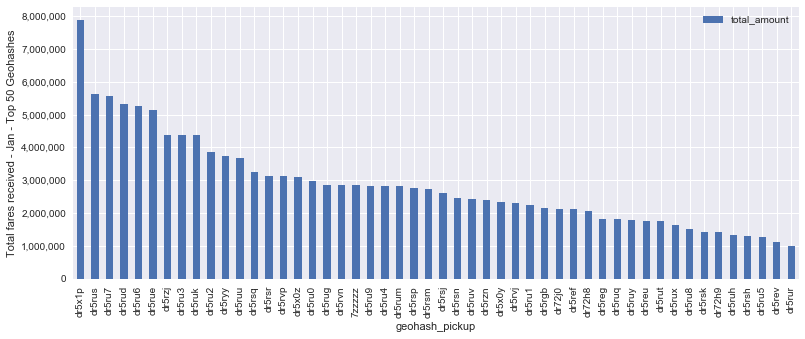

In [109]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

## Break up the day into five minute intervals( the time to traverse a geohash of ~610 meters).
- Aggregate all of the days together so that you have one 24 hour block
- For this 24 hour block, group by five minute periods
- For each period, take the geohash as the key and a list of tuples of ( average fares over the month, trip times in minutes)
- This gives an end result of the average fare and corresponding trip time and ration of fare/trip time for each geohash for a given ten minutes over each day in January

In [88]:
# Convert trip distance into minutes using the average speed of 10 MPH ( 8.6 in Manhattan + faster in the burbs)
def convert_miles_to_minutes_nyc(input_distance):
    """Convert MPH to minutes using aveage speed of 10 mph. Round to this nearest 10 minutes"""
    mph=10
    def myround(x, base=10):
        nearest_five = int(base * round(float(x)/base))
        if nearest_five ==0:
            return 10 ## shortest trip is ten minutes
        else:
            return nearest_five
    minutes = input_distance /mph *60
    return myround(minutes)
    
taxi_yellowcab_df['trip_time_minutes'] = taxi_yellowcab_df.trip_distance.apply(lambda x: convert_miles_to_minutes_nyc(x))

In [89]:
# distribution of trip times
trip_minutes_grouped = taxi_yellowcab_df.groupby('trip_time_minutes').count()

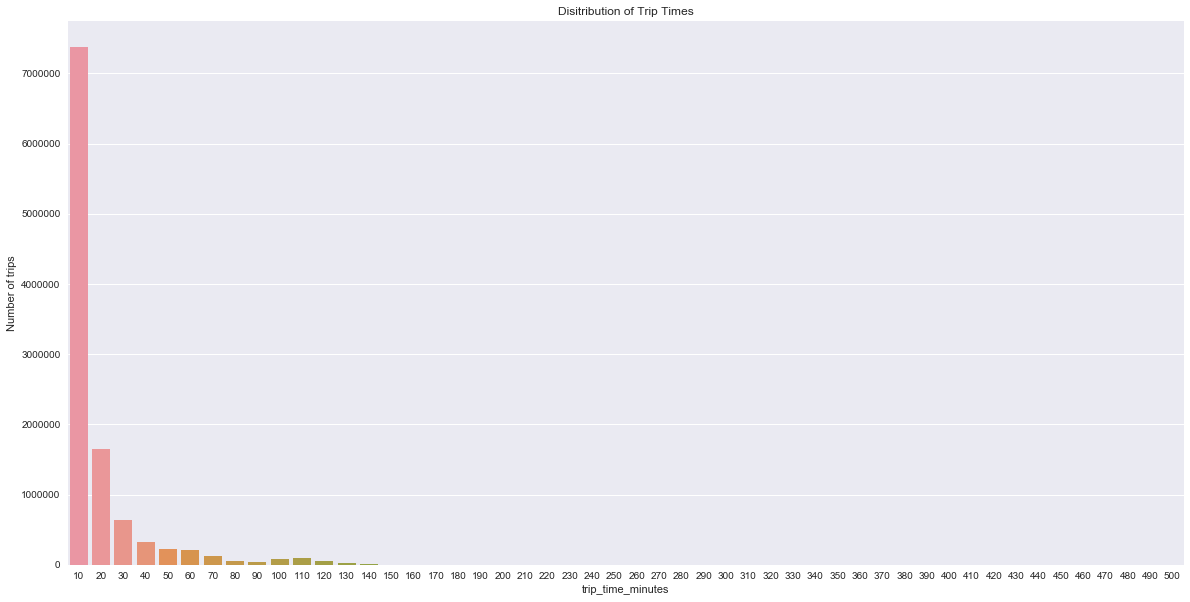

In [90]:
plt.figure(figsize=(20,10))
sns.barplot(x = trip_minutes_grouped['VendorID'].reset_index()['trip_time_minutes'][:50],
            y= trip_minutes_grouped['VendorID'].reset_index()['VendorID'][:50])
plt.ylabel('Number of trips')
plt.title('Disitribution of Trip Times')

In [91]:
taxi_yellowcab_df['trip_time_minutes'].head()

0    10
1    30
2    60
3    30
4    10
Name: trip_time_minutes, dtype: int64

In [92]:
# Only pull the columns we need 
average_fare_during_day = taxi_yellowcab_df.loc[:,('tpep_pickup_datetime','trip_time_minutes',
                            'tpep_dropoff_datetime','total_amount','geohash_dropoff','geohash_pickup','jan_day')]

In [93]:
average_fare_during_day.tpep_pickup_datetime = pd.to_datetime(average_fare_during_day.tpep_pickup_datetime)


In [94]:
average_fare_during_day.index = average_fare_during_day.tpep_pickup_datetime


In [95]:
average_fare_during_day.head()

,tpep_pickup_datetime,trip_time_minutes,tpep_dropoff_datetime,total_amount,geohash_dropoff,geohash_pickup,jan_day
tpep_pickup_datetime,,,,,,,
2016-01-01,2016-01-01,10,2016-01-01 00:00:00,8.8,dr5rsx,dr5rsr,1
2016-01-01,2016-01-01,30,2016-01-01 00:00:00,19.3,dr5rtk,dr5rsw,1
2016-01-01,2016-01-01,60,2016-01-01 00:00:00,34.3,dr72j1,dr5rkm,1
2016-01-01,2016-01-01,30,2016-01-01 00:00:00,17.3,dr5rkc,dr5rsh,1
2016-01-01,2016-01-01,10,2016-01-01 00:00:00,8.8,dr5rue,dr72hb,1


In [96]:
grouped_pickup_fares = average_fare_during_day.groupby(pd.TimeGrouper(freq='10Min')).apply(
    lambda x: x.groupby('geohash_pickup').mean())

In [97]:
grouped_pickup_fares  = grouped_pickup_fares.reset_index()

In [98]:
# groupby again only on minutes this time
grouped_pickup_fares['time'] = grouped_pickup_fares.tpep_pickup_datetime.apply(lambda x : x.time())

In [99]:
grouped_pickup_fares .head()

,tpep_pickup_datetime,geohash_pickup,trip_time_minutes,total_amount,jan_day,time
0,2016-01-01,7zzzzz,13.600000,14.466400,1.0,00:00:00
1,2016-01-01,dr5r56,20.000000,12.300000,1.0,00:00:00
2,2016-01-01,dr5r5t,10.000000,8.050000,1.0,00:00:00
3,2016-01-01,dr5r5x,50.000000,30.950000,1.0,00:00:00
4,2016-01-01,dr5rec,26.666667,16.873333,1.0,00:00:00


In [100]:
# change the trip time to be a factor of ten again
def myround(x, base=10):
        nearest_five = int(base * round(float(x)/base))
        if nearest_five ==0:
            return 10 ## shortest trip is ten minutes
        else:
            return nearest_five
grouped_pickup_fares.trip_time_minutes = grouped_pickup_fares.trip_time_minutes.apply(lambda x: myround(x))

In [101]:
average_fares_throughout_day_geohash = grouped_pickup_fares.groupby(
    ['time','geohash_pickup','jan_day','trip_time_minutes']).mean().reset_index()

In [102]:
average_fares_throughout_day_geohash['average_fare'] = average_fares_throughout_day_geohash['total_amount']
average_fares_throughout_day_geohash.drop('total_amount',inplace=True,axis=1)

In [103]:
## convert the string of time into an integer
def time_to_int(time):
    hour = str(time.hour)
    minutes = str(time.minute)
    if len(hour)==1:
        hour ='0'+hour
    if len(minutes)==1:
        minutes = '0'+minutes
    return int(hour+minutes)
average_fares_throughout_day_geohash.time = average_fares_throughout_day_geohash.time.apply(lambda x: time_to_int(x))

In [105]:
average_fares_throughout_day_geohash.head() # midnight is now 0

,time,geohash_pickup,jan_day,trip_time_minutes,average_fare
0,0,7zzzzz,1.0,10,14.466400
1,0,7zzzzz,2.0,20,16.222174
2,0,7zzzzz,3.0,20,15.456212
3,0,7zzzzz,4.0,20,20.873846
4,0,7zzzzz,5.0,30,18.542500


In [106]:
# Turn this into a dictionary where the key is the time : key is the geohas : value is a list of a tuple of fares,
# time, fare divided by time
# on average for that day for that geohash 

time_geohash_fare_dict = defaultdict(lambda : defaultdict(list))

In [107]:
for row in average_fares_throughout_day_geohash.iterrows():
    # Create a dict of dict of a list of tuples - tuple is (fare, trip-minutes, fare/trip-minutes)

    time_geohash_fare_dict[row[1]['time']][row[1]['geohash_pickup']].append(
    (row[1]['average_fare'],row[1]['trip_time_minutes'],row[1]['average_fare']/(row[1]['trip_time_minutes']+.000000001)))


In [111]:
# test the dictionary # fare followed by time in minutes)
time_geohash_fare_dict[110]['7zzzzz']

[(17.580441176470575, 20, 0.8790220587795776),
 (10.5425, 20, 0.5271249999736438),
 (14.17679245283018, 20, 0.708839622606067),
 (41.59181818181819, 20, 2.0795909089869298),
 (22.031818181818185, 20, 1.1015909090358298),
 (19.592777777777783, 20, 0.9796388888399072),
 (31.29833333333334, 20, 1.564916666588421),
 (22.080384615384617, 30, 0.7360128204882868),
 (19.280851063829783, 20, 0.964042553143287),
 (14.063272727272723, 20, 0.703163636328478),
 (20.34714285714286, 20, 1.017357142806275),
 (16.5105, 20, 0.8255249999587237),
 (20.550000000000004, 20, 1.0274999999486252),
 (12.45818181818182, 20, 0.6229090908779455),
 (21.872173913043483, 30, 0.7290724637438136),
 (21.339574468085097, 20, 1.0669787233509058),
 (14.037317073170733, 20, 0.7018658536234433),
 (15.70227272727273, 10, 1.5702272725702502),
 (19.242000000000004, 20, 0.9620999999518952),
 (14.77166666666667, 20, 0.7385833332964044),
 (16.407894736842106, 20, 0.8203947368010855),
 (18.439210526315787, 20, 0.9219605262696913),


In [110]:
# test the dictionary and ensure that the fare and the time changes, fare followed by time in minutes
time_geohash_fare_dict[1940]['dr5xs1']

[(105.3, 130, 0.8099999999937693)]

In [508]:
taxi_yellowcab_df[taxi_yellowcab_df['geohash_pickup']=='dr5xs1']

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,trip_time_minutes
1071945,1,2016-01-04 19:46:46,2016-01-04 19:47:27,1,22.3,-73.642105,40.702583,5,N,-73.642105,...,5.0,0.0,0.3,105.3,dr5xs1,dr5xs1,4,47,dr5xs1,135
2344969,1,2016-01-15 23:38:05,2016-01-15 23:38:33,1,0.0,-73.650696,40.702461,5,N,-73.650696,...,10.0,0.0,0.3,79.8,dr5xs1,dr5xs1,15,38,dr5xs1,5
9399489,1,2016-01-24 21:01:19,2016-01-24 21:02:25,1,0.0,-73.642448,40.702583,5,N,-73.642395,...,10.0,0.0,0.3,45.3,dr5xs1,dr5xs1,24,2,dr5xs1,5


## Index the geohashes to a number
## List of possible times

In [134]:
## get a list of unique geohashes
list_of_unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(list_of_unique_geohashes)

3086

In [135]:
list_of_geohash_index  = defaultdict(int)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_geohash_index [hash_n] = idx

In [140]:
list_of_inverse_heohash_index = defaultdict(str)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_inverse_heohash_index[idx] = hash_n

In [141]:
list_of_time_index = average_fares_throughout_day_geohash.time.unique()

In [142]:
list_of_time_index

array([   0,   10,   20,   30,   40,   50,  100,  110,  120,  130,  140,
        150,  200,  210,  220,  230,  240,  250,  300,  310,  320,  330,
        340,  350,  400,  410,  420,  430,  440,  450,  500,  510,  520,
        530,  540,  550,  600,  610,  620,  630,  640,  650,  700,  710,
        720,  730,  740,  750,  800,  810,  820,  830,  840,  850,  900,
        910,  920,  930,  940,  950, 1000, 1010, 1020, 1030, 1040, 1050,
       1100, 1110, 1120, 1130, 1140, 1150, 1200, 1210, 1220, 1230, 1240,
       1250, 1300, 1310, 1320, 1330, 1340, 1350, 1400, 1410, 1420, 1430,
       1440, 1450, 1500, 1510, 1520, 1530, 1540, 1550, 1600, 1610, 1620,
       1630, 1640, 1650, 1700, 1710, 1720, 1730, 1740, 1750, 1800, 1810,
       1820, 1830, 1840, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 2000,
       2010, 2020, 2030, 2040, 2050, 2100, 2110, 2120, 2130, 2140, 2150,
       2200, 2210, 2220, 2230, 2240, 2250, 2300, 2310, 2320, 2330, 2340,
       2350])

# Use an Actor Critic Model
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [75]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S

In [41]:
## Actor
HIDDEN1_UNITS=10
HIDDEN2_UNITS=20
state_size=5
print("Now we build the model")
S = Input(shape=[state_size])
h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)

Steering = Dense(1,activation='tanh')(h1)   
Acceleration = Dense(1,activation='sigmoid')(h1)   
Brake = Dense(1,activation='sigmoid')(h1)   
V = Concatenate([Steering,Acceleration,Brake])

model = Model(inputs=S,output=[Steering,Acceleration,Brake])
model.summary()
print("We finished building the model")


Now we build the model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
dense_75 (Dense)                 (None, 10)            60                                           
____________________________________________________________________________________________________
dense_76 (Dense)                 (None, 20)            220                                          
____________________________________________________________________________________________________
dense_77 (Dense)                 (None, 1)             21                                           
____________________________________________________________________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  '` call to the Keras 2 API: ' + signature)


In [50]:
## Critic
action_dim = 100
S = Input(shape=[state_size])
A = Input(shape=[action_dim],name='action2')    
w1 = Dense(HIDDEN1_UNITS, activation='relu')(S)
a1 = Dense(HIDDEN2_UNITS, activation='linear')(A)
h1 = Dense(HIDDEN2_UNITS, activation='linear')(w1)
h2 = Add(h1,a1)    
h3 = Dense(HIDDEN2_UNITS, activation='relu')(h2)
V = Dense(action_dim,activation='linear')(h3) 

model = Concatenate(input=[S,A],output=V)

adam = Adam(lr=self.LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)
print("We finished building the model")

TypeError: __init__() takes 1 positional argument but 3 were given

In [115]:
# parameters
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 9 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 3200. # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4

In [116]:
##define some test inputs , time, state
X = np.array([[10,2],
             [100,23]])

In [117]:
##Define a simple model where the output is a softmax probability over the eight states
# Inputs will be the time, current geohash-index ()
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
model_simple = Sequential()
model_simple.add(Dense(100, activation='relu', input_shape= (2,)))
model_simple.add(Dropout(.3))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dropout(.3))
model_simple.add(Dense(9, activation='softmax')) ## predict which geohash to move to next
adam = Adam(lr=LEARNING_RATE)
model_simple.compile(loss='mse',optimizer=adam)
model_simple.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 909       
Total params: 11,309.0
Trainable params: 11,309.0
Non-trainable params: 0.0
_________________________________________________________________


In [118]:
model_simple.predict(X)

array([[  7.98309818e-02,   1.55236691e-01,   3.14950645e-02,
          1.21006086e-01,   6.96885511e-02,   1.38656586e-01,
          2.61261910e-01,   1.34518713e-01,   8.30531400e-03],
       [  9.32408693e-06,   4.56102332e-03,   7.78411891e-10,
          9.39506688e-04,   1.72726493e-06,   2.20192061e-03,
          9.90400016e-01,   1.88641425e-03,   1.47626609e-15]], dtype=float32)

In [256]:
list_of_geohash_index[np.random.choice(list_of_unique_geohashes)] # index of geohash

770

In [259]:
np.random.choice(list_of_time_index) # time

1410

In [271]:
np.array([[np.random.choice(list_of_time_index),
                     list_of_geohash_index[np.random.choice(list_of_unique_geohashes)]]])
    

array([[ 605, 2775]])

In [278]:
random.randrange(ACTIONS)

8

In [164]:
def trainNetworkNeuralNetworkTaxicab(model, list_of_unique_geohashes):
    # Code adapted from https://github.com/yanpanlau/Keras-FlappyBird/blob/master/qlearn.py
    ## pick a random state and time to start at
    
    # store the previous observations in replay memory
    D = deque()
    
    # get the first state by randomlly choosing a geohash to start at and random time to start at
    # Assume that the first state has no reward associated with it
    starting_geohash = np.random.choice(list_of_unique_geohashes)
    starting_time = np.random.choice(list_of_time_index)
    s_t = np.array([[starting_time,
                     list_of_geohash_index[starting_geohash]]])
    print(s_t,'starting time and geohash index')
    args = {'None':0}
    try:
        args['mode'] == 'Run' ## don't need this
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    except KeyError:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON
        
    #start your observations
    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        print(t, ' t')
        #choose a random action action epsilon greedy
        if t % FRAME_PER_ACTION == 0: ## will always choose this if frame per action is 1
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS) # Randomlly choose another geohash to go to
                a_t[action_index] = 1
            else:
                print('---------Not a random action------------')
                q = model.predict(s_t)       #input the time followed by the geohash index
                max_Q = np.argmax(q)  # find the position of the highest probability (which direction to go in)
                action_index = max_Q
                a_t[max_Q] = 1
                
        #We reduced the epsilon gradually to take more random actions 
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
            
        print(a_t,'a_t')
        print(starting_geohash,'starting geohash')
        print(starting_time,'starting time')
        print(action_index,'action Index')
        print(list_of_output_predictions_to_direction[np.argmax(a_t)],'direction to take')
        print(action_index,'action index')
            
        #run the selected action and observed next state and reward
        # We need to find the neighbors to the geohash that we started at
        
        #Get the neighbors from the current geohash
        neighbors = gh.neighbors(starting_geohash)
        # Get the direction we should go
        direction_to_move_to = list_of_output_predictions_to_direction[action_index]
        # Get the geohash of the direction we moved to
        if direction_to_move_to =='stay':
            new_geohash = starting_geohash
        else:
            new_geohash = neighbors[direction_to_move_to]
        
        print(new_geohash,'new geohash we moved to')
        
        # get the reward of the geohash we just moved to (this is the ratio of fare /time of trip)
        possible_rewards = np.array(time_geohash_fare_dict[starting_time][new_geohash])

        if len (possible_rewards) ==0:
            r_t = 0 ## we do not have information for this time and geohash, don't go here. No reward
        else:
            r_t =  possible_rewards[np.random.randint(0,len(possible_rewards))][2] # get the ratio of fare / trip time
            #r_t = np.random.choice(possible_rewards)
        print(r_t,'reward')
        
#         x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        

#         x_t1 = skimage.color.rgb2gray(x_t1_colored)
#         x_t1 = skimage.transform.resize(x_t1,(80,80))
#         x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))

#         x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
#         s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

#         # store the transition in D
#         D.append((s_t, action_index, r_t, s_t1, terminal))
#         if len(D) > REPLAY_MEMORY:
#             D.popleft()

            
#         #gh.neighbors()
        
        break

In [143]:
list_of_output_predictions_to_direction[3]

'w'

In [144]:
t = np.array([(2,4),(4,6),(5,7),(2,4),(2,7)])

In [145]:
t[np.random.randint(0,len(t))]

array([2, 4])

In [146]:
gh.neighbors('dr5qym')

{'e': 'dr5qys',
 'n': 'dr5qyn',
 'ne': 'dr5qyt',
 'nw': 'dr5qyl',
 's': 'dr5qyj',
 'se': 'dr5qyp',
 'sw': 'dr5qyh',
 'w': 'dr5qyk'}

In [147]:
time_geohash_fare_dict[1630]['7zzzzz']

[(17.356875, 20, 0.8678437499566077),
 (15.7734693877551, 20, 0.7886734693483213),
 (20.898399999999988, 20, 1.0449199999477534),
 (21.793265306122432, 20, 1.0896632652516385),
 (18.329047619047607, 20, 0.9164523809065578),
 (20.25743589743589, 10, 2.0257435895410145),
 (14.625675675675678, 20, 0.7312837837472197),
 (16.576153846153847, 20, 0.828807692266252),
 (18.028269230769222, 20, 0.9014134614933904),
 (19.57571428571429, 20, 0.9787857142367753),
 (19.620454545454535, 20, 0.9810227272236757),
 (16.211020408163257, 10, 1.6211020406542156),
 (17.781999999999993, 20, 0.8890999999555447),
 (18.681724137931027, 20, 0.9340862068498471),
 (20.890606060606068, 20, 1.0445303029780768),
 (11.152380952380957, 10, 1.115238095126572),
 (14.446491228070164, 10, 1.4446491226625515),
 (17.977173913043465, 20, 0.8988586956072303),
 (16.310833333333328, 20, 0.8155416666258893),
 (18.515999999999988, 20, 0.9257999999537094),
 (20.83599999999998, 20, 1.041799999947909),
 (18.19490909090908, 20, 0.909

In [165]:
c=0
while c < 10:
    trainNetworkNeuralNetworkTaxicab(model_simple, list_of_unique_geohashes)
    c+=1

[[1250 1604]] starting time and geohash index
0  t
---------Not a random action------------
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.] a_t
dr5qud starting geohash
1250 starting time
6 action Index
sw direction to take
6 action index
dr5quW new geohash we moved to
0 reward
[[ 430 2399]] starting time and geohash index
0  t
---------Not a random action------------
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.] a_t
dr54wb starting geohash
430 starting time
3 action Index
w direction to take
3 action index
dr54wZ new geohash we moved to
0 reward
[[ 120 1294]] starting time and geohash index
0  t
---------Not a random action------------
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.] a_t
dr5xg6 starting geohash
120 starting time
3 action Index
w direction to take
3 action index
dr5xg4 new geohash we moved to
0 reward
[[450 767]] starting time and geohash index
0  t
---------Not a random action------------
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.] a_t
dr72wd starting geohash
450 starting time
3 action Index
w direction

In [385]:
model_simple.predict(np.array([[1950,2138]]))

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [386]:
def trainNetwork(model,args):
    # open up a game state to communicate with emulator 
    game_state = game.GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(80,80))
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    #print (s_t.shape)

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4
    
    if args['mode'] == 'Run': ## don't need this
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON

    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1

        #We reduced the epsilon gradually to take more random actions 
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        #run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1,(80,80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))

        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE:
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)



            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 80, 80, 4
            print (inputs.shape)
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                terminal = minibatch[i][4]
                # if terminated, only equals reward

                inputs[i:i + 1] = state_t    #I saved down s_t

                targets[i] = model.predict(state_t)  # Hitting each buttom probability
                Q_sa = model.predict(state_t1)

                if terminal:
                    targets[i, action_t] = reward_t
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)

        s_t = s_t1
        t = t + 1

        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            model.save_weights("model.h5", overwrite=True)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")